In [207]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle
import pandas as pd
import sklearn
%matplotlib inline

# Import and process data

In [208]:
illPat = np.genfromtxt("./inData/clean_ecg/s0014lre.txt")
healthPat = np.genfromtxt("./inData/clean_ecg/s0303lre.txt")
dhealthPat = np.diff(healthPat[0:,1])
dillPat = np.diff(illPat[0:,1])
print("Input shape for ill and healthy:", illPat.shape, healthPat.shape)
print("Differentiated shape for ill and healthy:", dillPat.shape, dhealthPat.shape)

# Various plots...
#plt.plot(illPat[0:5000,1])
#plt.plot(healthPat[0:5000,1])
#plt.plot(dhealthPat[0:50000])
#plt.plot(dillPat[0:500])

Input shape for ill and healthy: (115200, 16) (115200, 16)
Differentiated shape for ill and healthy: (115199,) (115199,)


In [209]:
def findAbove(arr, threshold):
    """
    Return indices for values above threshhold in array, arr.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
    return inlst

def getSamples(arr, peakArr, buffer):
    """
    Get samples for array arr with buffer each side of peak indices, in peakArr.
    """
    sampledData = []
    for i in peakArr:
        if len(arr[i-buffer: i+buffer]) == buffer*2: # Check that all samples are same size
            sampledData.append(arr[i-buffer: i+buffer])
        
    return sampledData

def shuffle2Lst(list1, list2):
    """ 
    Shuffle two lists in similar ways.
    """
    list1_shuf = []
    list2_shuf = []
    index_shuf = np.arange(len(list1))
    shuffle(index_shuf)
    for i in index_shuf:
        list1_shuf.append(list1[i])
        list2_shuf.append(list2[i])
    return list1_shuf, list2_shuf

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

buffer = 150
peakArr = findAbove(dillPat, 0.09)
illSampled = getSamples(dillPat, peakArr, buffer)
peakArr = findAbove(dhealthPat, 0.04)
healthSampled = getSamples(dhealthPat, peakArr, buffer)

print(len(illSampled))
print(len(healthSampled))

classData = []
for i in np.arange(0, len(illSampled), 1):
    classData.append(1)
for i in np.arange(0, len(healthSampled), 1):
    classData.append(0)
ecgData = illSampled + healthSampled
classData, ecgData = shuffle2Lst(classData, ecgData)
classDataOH = processClassData(classData)

555
480


In [210]:
ecgData = np.reshape(np.concatenate(ecgData, axis=0), [len(ecgData), buffer*2, 1])

0


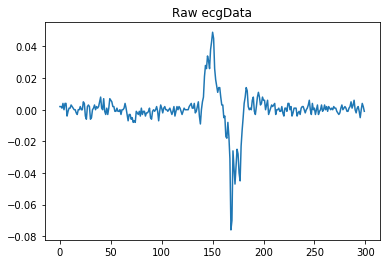

In [216]:
plt.plot(ecgData[115])
plt.title("Raw ecgData")
print(classData[115])

# Neural Network

In [212]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 300, 1])
    
# First layer:
net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, activation="leaky_relu")

# Fully connected layer 2:
# net = tflearn.layers.core.fully_connected(net, 256, activation="relu")

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [213]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(ecgData, classDataOH, show_metric=True)

Training Step: 170  | total loss: 0.44793
| Adam | epoch: 010 | loss: 0.44793 - acc: 0.8950 -- iter: 1035/1035
Training Step: 170  | total loss: 0.44793
| Adam | epoch: 010 | loss: 0.44793 - acc: 0.8950 -- iter: 1035/1035
--


In [218]:
run0 = np.genfromtxt("./outData/cleanEcg2017-02-12/run0.csv", delimiter=",")
run1 = np.genfromtxt("./outData/cleanEcg2017-02-12/run1.csv", delimiter=",")
run2 = np.genfromtxt("./outData/cleanEcg2017-02-12/run2.csv", delimiter=",")
run3 = np.genfromtxt("./outData/cleanEcg2017-02-12/run3.csv", delimiter=",")

run0[0]